# 028 Tree silhouette and monophyly scores
* depends on results from 026.concat_resolution (specially the trees)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from Bio import Seq, SeqIO, Align, AlignIO, Phylo, Alphabet, pairwise2 
from Bio.SeqRecord import SeqRecord
from Bio.Align import AlignInfo, Applications
from Bio.Phylo import draw, TreeConstruction # TreeConstruction.DistanceTreeConstructor 
# https://bioinformatics.stackexchange.com/questions/4337/ \
#biopython-phylogenetic-tree-replace-branch-tip-labels-by-sequence-logos

import numpy as np
import seaborn as sns
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import skbio, parasail, dendropy, pandas
import sys, gzip, re, glob, pickle, collections, subprocess, os, errno, random, itertools

def print_redblack(textr, textbb="", textbl=""):
    print ('\x1b[0;1;31;1m'+ str(textr) + '\x1b[0;1;30;1m'+ str(textbb) + '\x1b[0;0;30;0m'+ str(textbl) + '\x1b[0m')

## read taxonomic information
- we don't need the file location anymore (unlike notebook 026), but the GTDB table is usefull if we want to 'rename' the tree leaves (using e.g. NCBI names). We create a dictionary from table, using accession numbers as keys.
- this is achieved by the function of the second cell, which receives a name `genus_species_accession` (where the binomial by default, i.e. notebook 026, is GTDB), and gets a new `genus_species` based on `accession` using other columns of GTDB table:

| column | taxon database|
| --- | --- |
| 0 |  GTDB |
| 1 |  SILVA 23S |
| 3 | NCBI |
| 4 | SILVA 16S |

In [2]:
gbff_dir = "/media/deolivl/QIB_deolivl/bigdata/"   ## directory (or directories, in our case) with refseq genomes
#gbff_dir = "./bigdata/"

tmp_table = [line.strip() for line in open("./bigdata/gtdb_list.csv", 'r')]
print_redblack("header: <file>  ", tmp_table[0].split(',')[1:]) ## first column is data.frame index from R
tmp_table = [line.split(',')[1:] for line in tmp_table[1:]] ## skip first line, with headers
sp_tbl_dict = { str(re.search('GCF_(\d+)\.', x[0]).group(1)): x[1:] for x in tmp_table} # key:value 

k = list(sp_tbl_dict)[1];  print ("first element of list: ", k, sp_tbl_dict[k], "\n")

header: <file>  ['accession', 'gtdb_taxonomy', 'lsu_silva_23s_taxonomy', 'ncbi_organism_name', 'ncbi_taxonomy', 'ssu_silva_taxonomy']
first element of list:  000494775 ['Campylobacter_D coli', 'Campylobacter jejuni K5', 'Campylobacter coli 15-537360', 'Campylobacter coli', 'Campylobacter jejuni 30318'] 



In [3]:
## receives a leaf name and returns a new leaf name preserving accession but changing taxonomy DB
def leaf_name_from_leaf_name (leaf_str, tbl_col = 3):
    accession = leaf_str.split(".")[2]
    try:
        binstr = ".".join(sp_tbl_dict[accession][tbl_col].split()[:2])
    except:
        binstr = "unknown.unknown"
    binstr += "." + accession
    return binstr

def change_leaf_names_from_db (tree, tbl_col=3):
    for tx in tree.taxon_namespace:
        tx.label = leaf_name_from_leaf_name (tx.label, tbl_col)
    return tree

## labels of genes and merged sets must follow order
- for printing and visualising only
- we assume that trees already exist (otherwise 026 notebook must be run, or trees created by hand)

In [4]:
outdir = "./026_results/"
ordered_types = ["5S","16Sv1v2","16Sv3v4","16S","23S","16S5S","23S5S","16S23S","16S23S5S"]
outfile_list = [outdir + str(keys) for keys in ordered_types] # for this data set we know order :D 
print (outfile_list)

['./026_results/5S', './026_results/16Sv1v2', './026_results/16Sv3v4', './026_results/16S', './026_results/23S', './026_results/16S5S', './026_results/23S5S', './026_results/16S23S', './026_results/16S23S5S']


## Tree silhouette score
- calculating the patristic distance between leaves in a tree is the first component of the tree silhouette score, and is calculated with the dendropy package 
- the second component is the silhouette score, implemented in the scikit-learn library 
- the function below calculates both, and furthermore:
    1. "shuffles" the tree, i.e. maintain the leaf names but randomise branches, generating a "null model"
    2. change leaf names using GTDB taxonomy, if necessary

In [5]:
def patristic_distances_from_treefile (filename, tbl_col = -1, have_paralogs = False, shuffle = False):
    tree = dendropy.Tree.get(path=filename, schema="newick", preserve_underscores=True)
    if (tbl_col >= 0):
        tree = change_leaf_names_from_db (tree, tbl_col)
    if shuffle:
        tree = dendropy.simulate.treesim.pure_kingman_tree(taxon_namespace=tree.taxon_namespace, pop_size = 1000)
    species = ['.'.join(t.label.split('.')[:2]) for t in tree.taxon_namespace] ## follow order of taxon_namespace
    ntaxa = len(tree.taxon_namespace)
    distmat = np.zeros((ntaxa,ntaxa)) # diagonals are zero
    nodemat = np.zeros((ntaxa,ntaxa))
    ## STEP 1: pairwise distances along the tree
    pdm = tree.phylogenetic_distance_matrix() # initialises class
    for i,j in itertools.combinations(range(ntaxa),2):
        distmat[i,j] = distmat[j,i] = pdm.distance(tree.taxon_namespace[i], tree.taxon_namespace[j])
        nodemat[i,j] = nodemat[j,i] = pdm.path_edge_count(tree.taxon_namespace[i], tree.taxon_namespace[j])
    ## STEP 2: silhouette score using pairwise distances and taxonomic information
    mdist = metrics.silhouette_samples(distmat, species, metric="precomputed")
    mnode = metrics.silhouette_samples(nodemat, species, metric="precomputed")
    if have_paralogs:
        sample = ['.'.join(t.label.split('.')[:3]) for t in tree.taxon_namespace]
        m3 = metrics.silhouette_samples(distmat, sample, metric="precomputed")
        m4 = metrics.silhouette_samples(nodemat, sample, metric="precomputed")
        return mdist, mnode, m3, m4
    return mdist, mnode

def silhouette_str(distrib):
    return '{:7.3f}'.format(np.percentile(distrib, 5)) + \
    '{:7.3f}'.format(np.percentile(distrib, 25)) + \
    '{:7.3f}'.format(np.percentile(distrib, 50)) + \
    '{:7.3f}'.format(np.percentile(distrib, 75)) + \
    '{:7.3f}  '.format(sum(distrib>0)/float(len(distrib)))
silhouette_str_head="5%  25%  50%  75%  proportion_positives   <-- weighted | unweighted -->"

In [67]:
mdis, mnod = patristic_distances_from_treefile (outfile_list[0]+ "_long.fasta.treefile", shuffle = True)
# bar plot uses path difference
bplot_label = ["random"] ; bplot_hue = ["proportion of positive silhouette scores"]; 
bplot_value = [sum(mnod>0)/float(len(mnod))]
# violin plots use weighted distances
vio_silho_x = ["random"] * mdis.shape[0];  vio_silho_y = list(mdis)

print (silhouette_str_head)
print ('     {:9s}'.format("random"), "\t", silhouette_str(mdis),  silhouette_str(mnod))

suffix1 = ".fasta.treefile"
for suffix2, title in zip (["_long", "_consensus"], ["long ", "cons "]):
#for suffix2, title2 in zip (["_consensus"], ["cons "]): ## testing, on consensus only
    suffix = suffix2 + suffix1;
    for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
        mdis, mnod = patristic_distances_from_treefile (fname + suffix)
        print (title + '{:6s}'.format(rname), "\t", silhouette_str(mdis),  silhouette_str(mnod))
        if "long" in title:
            bplot_label.append(rname) ; bplot_hue.append("proportion of positive silhouette scores");
            bplot_value.append(sum(mnod>0)/float(len(mnod)))
            vio_silho_x.extend([str(rname)] * mdis.shape[0]); vio_silho_y.extend(list(mdis))
    print("\t_")

5%  25%  50%  75%  proportion_positives   <-- weighted | unweighted -->
     random    	  -0.640 -0.510 -0.414 -0.275  0.014    -0.319 -0.243 -0.199 -0.160  0.013  
long 5S     	  -0.990 -0.158  0.845  0.981  0.728    -0.699 -0.317  0.179  0.490  0.607  
long 16Sv1v2 	  -0.977  0.243  0.855  0.956  0.827    -0.499 -0.157  0.187  0.401  0.657  
long 16Sv3v4 	  -0.998  0.309  0.891  0.994  0.759    -0.770 -0.142  0.219  0.551  0.621  
long 16S    	  -0.327  0.017  0.753  0.955  0.780    -0.344 -0.069  0.181  0.400  0.706  
long 23S    	  -0.259  0.484  0.871  0.959  0.927    -0.327  0.117  0.319  0.449  0.846  
long 16S5S  	  -0.287  0.029  0.796  0.958  0.767    -0.373 -0.050  0.183  0.408  0.679  
long 23S5S  	  -0.380  0.517  0.874  0.957  0.880    -0.418  0.115  0.346  0.477  0.817  
long 16S23S 	  -0.124  0.496  0.865  0.953  0.925    -0.309  0.117  0.308  0.433  0.841  
long 16S23S5S 	  -0.197  0.471  0.861  0.953  0.924    -0.327  0.087  0.335  0.466  0.827  
	_
cons 5S     	  -1.

## Monophyly scores
- the main score is the monophyly score $M$: for each species $S$ we find MRCA node $o$, and $M=|S|/|o|$ (where $|x|$ is the number of samples from species $x$ or below node $x$). Values are between $1/(N-2)$ (for $N$ samples/leaves) and one, with one meaning (perfect) monophyly.
- we also calculate the "proportion of species" $1/||o||$ for all MRCA nodes $o$, where $||o||$ is the number of distinct species (not samples) below node $o$. It corresponds to an unscaled version of $M$, since it doesn't take into account how many samples from each species is below the node. Values between $1/\epsilon$ and one, with one meaning no paraphyly ($\epsilon=$number of distinct species in tree).  
- finally we calculate the average patristic distance below all monophyletic nodes -- there are more monophyletic nodes than MRCA nodes, since each MRCA can be composed of several monophyletic nodes plus paraphyletic species. Therefore, for each species we report the "best" (i.e. higher) such average distance, together with the mean over the nodes. The higher these values, the better, since it means that for this species you have a monophyletic node (=correctly classified) with diverse sequences below it.

We have one value per species for all scores. 

In [6]:
def sp_list_from_labels (labels):
    return ['.'.join(t.split('.')[:2]) for t in labels]

def genera_set_from_namespace (txnamespace):
    x = [t.label.split('.')[0] for t in txnamespace]
    return set(x)

def taxa_list_from_strain (leaves, strain): # strain is list of species or genera
    return [x for x in leaves if strain in x]

def average_lengths_lca (samples, tre, pdm, lca): ## assumes names are unique
    taxon_label_list = [tre.find_node_with_taxon_label(x) for x in samples]
    avge = {} 
    for t in taxon_label_list:
        if t.label not in avge: ## not calculated yet
            is_mono = True
            mono_taxa = None
            while is_mono and t is not lca:
                t = t.parent_node
                taxa_below = [x for x in tre.taxon_namespace.bitmask_taxa_list(t.leafset_bitmask)]
                is_mono = all([i.label in samples for i in taxa_below])
                if (is_mono):
                    mono_taxa = [x for x in taxa_below]
            if mono_taxa:
                pairdist = np.mean([pdm.distance(i, j) for i,j in itertools.combinations(mono_taxa,2)])
                for i in mono_taxa:
                    avge[i.label] = pairdist
            else:
                avge[t.label] = 0.
    all_avges = [v for k,v in avge.items()]
    return max(all_avges), np.mean(all_avges)

def monophyly_score_from_treefile (filename, tbl_col = -1, shuffle = False):
    tree = dendropy.Tree.get(path=filename, schema="newick", preserve_underscores=True)
    if (tbl_col >= 0):
        tree = change_leaf_names_from_db (tree, tbl_col)
    if shuffle:
        x = tree.length()
        tree = dendropy.simulate.treesim.pure_kingman_tree(taxon_namespace=tree.taxon_namespace, pop_size = 5000)
        for edge in tree.preorder_edge_iter():
            edge.length = edge.length/x
    else: 
        tree.reroot_at_midpoint(update_bipartitions=True)
    tree.encode_bipartitions()
    pdm = tree.phylogenetic_distance_matrix() # initialises patristic distance class
    leaf_list = [x.label for x in tree.taxon_namespace]
    freq_species = [] ; monoscore = []; max_avge = []; avge_avge = []
    for sp in set(sp_list_from_labels(leaf_list)): # for each species
        samples_from_sp = taxa_list_from_strain (leaf_list, sp)
        mrca = tree.mrca(taxon_labels=samples_from_sp) # MRCA node of rooted tree is MRCA edge of unrooted tree
        samples_below_mrca = [x.label for x in tree.taxon_namespace.bitmask_taxa_list(mrca.leafset_bitmask)]
        samples_above_mrca = [x for x in leaf_list if x not in samples_below_mrca] # unrooted tree
        try: 
            m1 = len(samples_from_sp)/len(samples_below_mrca)
        except:
            m1 = len(samples_from_sp)/len(samples_above_mrca)
        monoscore.append(m1)
        try:
            m1 = 1./len(set(sp_list_from_labels(samples_below_mrca)))
        except:
            m1 = 1./len(set(sp_list_from_labels(samples_above_mrca)))
        freq_species.append(m1)
        x1, x2 = average_lengths_lca (samples_from_sp, tree, pdm, mrca)
        max_avge.append(x1)
        avge_avge.append(x2)
        #print (samples_above_mrca)
    return monoscore, freq_species, max_avge, avge_avge

def mono_str(mono_, freq_, mav_, avv_): ## was 25 and 50, now 5 and 25
    return '{:6.3f} '.format(np.percentile(mono_, 5)) + \
    '{:6.3f} '.format(np.percentile(mono_, 10)) + \
    '{:6.3f} '.format(np.percentile(mono_, 25)) + \
    '{:6.3f}\t\t'.format(sum(np.array(freq_) > 0.9)/float(len(freq_))) + \
    '{:.7f}\t'.format(np.percentile(mav_, 50)) + \
    '{:.7f}\t'.format(np.percentile(mav_, 95)) + \
    '{:.7f}\t'.format(np.percentile(avv_, 50)) + \
    '{:.7f}\t'.format(np.percentile(avv_, 95))

mono_str_head="\tmonoph_5% monoph_10% monoph_25% prop_species>0.9 \t max_avge_50% max_avge_95% mean_avge_50% mean_avge_95%\n"

In [71]:
mono, fspec, mav, avv = monophyly_score_from_treefile (outfile_list[0]+ "_consensus.fasta.treefile", shuffle = True)
bplot_label.append("random") ; bplot_hue.append("proportion of monophyletic groups")
bplot_value.append(sum(np.array(fspec) > 0.999)/float(len(fspec)))
vio_mono_x = ["random"] * len(mono)
vio_mono_y = mono; vio_mav_y = mav

print (mono_str_head)
print ('{:9s}'.format("random"), "\t", mono_str(mono, fspec, mav, avv))

suffix1 = ".fasta.treefile"
for suffix2, title in zip (["_long", "_consensus"], ["long ", "cons "]):
    suffix = suffix2 + suffix1;
    for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
        mono, fspec, mav, avv = monophyly_score_from_treefile (fname + suffix)
        print (title + '{:7s}'.format(rname), "\t", mono_str(mono, fspec, mav, avv))
        if "long" in title:
            bplot_label.append(rname) ; bplot_hue.append("proportion of monophyletic groups")
            bplot_value.append(sum(np.array(fspec) > 0.999)/float(len(fspec)))
            vio_mono_x.extend([rname] * len(mono))
            vio_mono_y.extend(mono); vio_mav_y.extend(mav);
    print("\t_")

	monoph_5% monoph_10% monoph_25% prop_species>0.9 	 max_avge_50% max_avge_95% mean_avge_50% mean_avge_95%

random    	  0.007  0.007  0.009  0.000		0.0000000	0.0000000	0.0000000	0.0000000	
long 5S      	  0.018  0.081  0.174  0.488		0.0000017	0.0074946	0.0000011	0.0074946	
long 16Sv1v2 	  0.039  0.066  0.299  0.558		0.0004373	0.0084735	0.0004373	0.0067716	
long 16Sv3v4 	  0.065  0.117  0.439  0.651		0.0000038	0.0040991	0.0000034	0.0040991	
long 16S     	  0.228  0.278  0.958  0.721		0.0019220	0.0206461	0.0016651	0.0206461	
long 23S     	  0.226  0.445  1.000  0.744		0.0021754	0.0101654	0.0021030	0.0101465	
long 16S5S   	  0.101  0.268  0.758  0.698		0.0019289	0.0184734	0.0017763	0.0184734	
long 23S5S   	  0.275  0.479  1.000  0.791		0.0026892	0.0100365	0.0024991	0.0100153	
long 16S23S  	  0.277  0.483  1.000  0.837		0.0031137	0.0133675	0.0031137	0.0133675	
long 16S23S5S 	  0.255  0.485  1.000  0.837		0.0032471	0.0140546	0.0031245	0.0140546	
	_
cons 5S      	  0.077  0.102  0.242  0.465

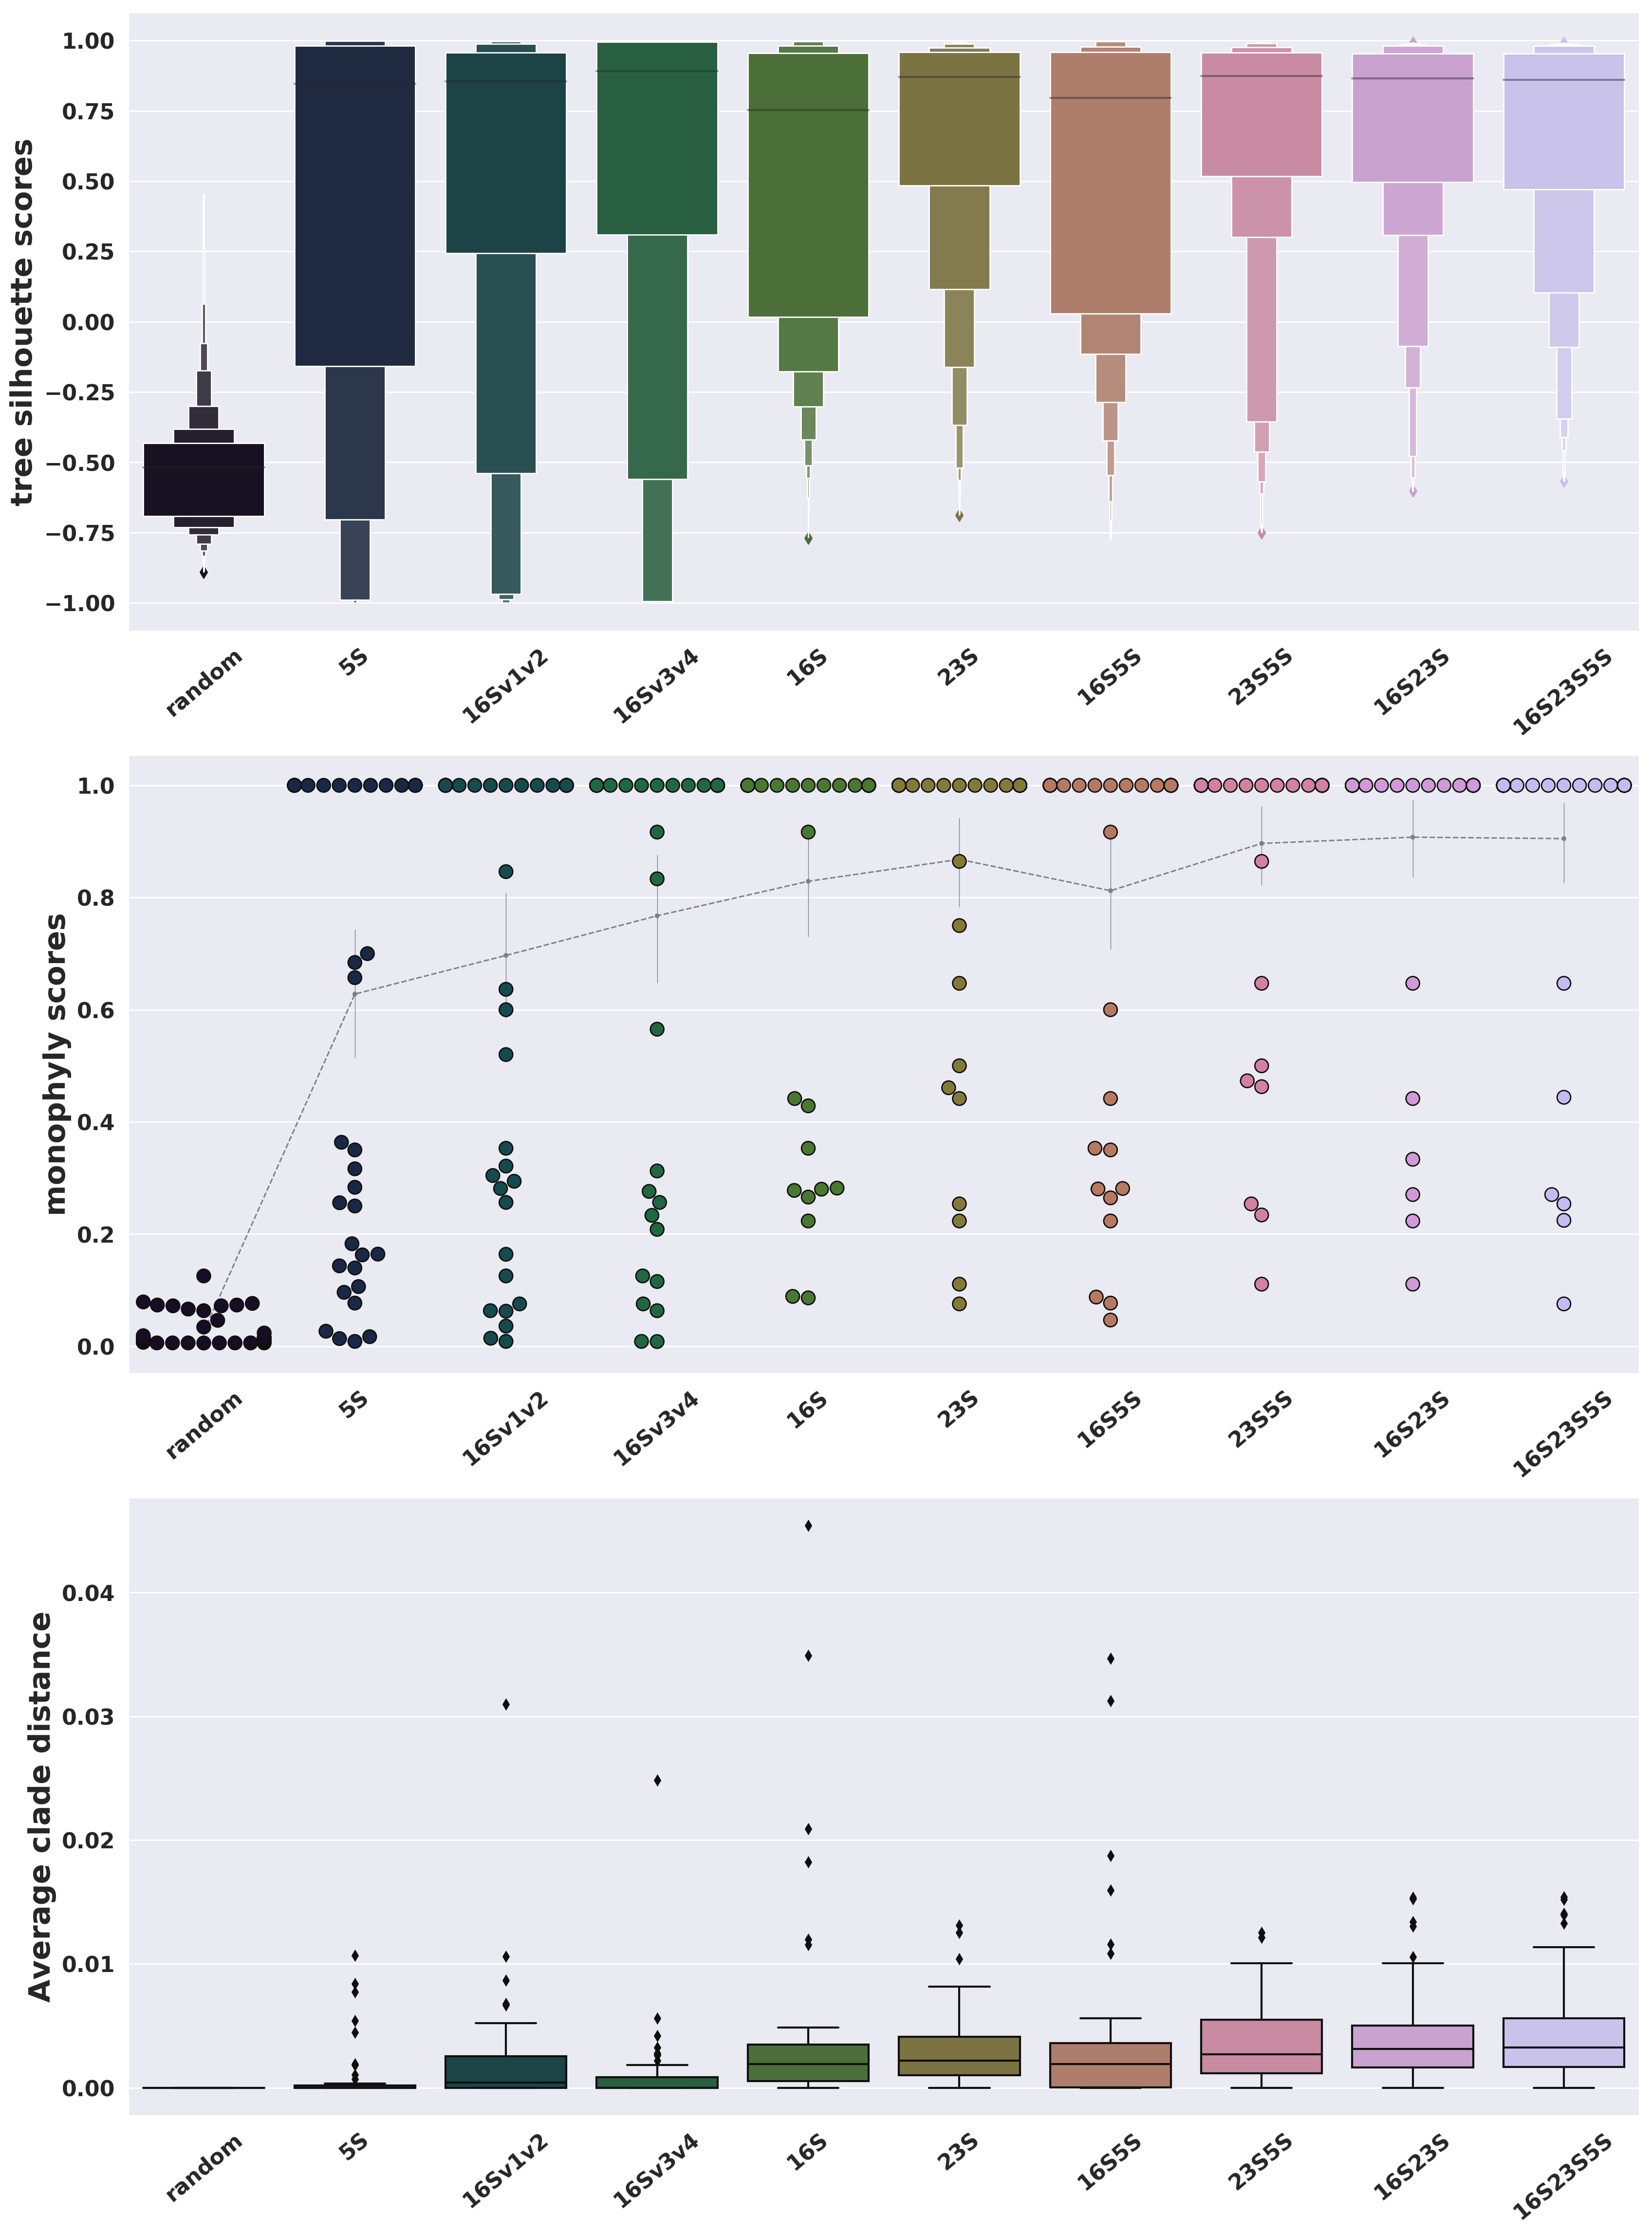

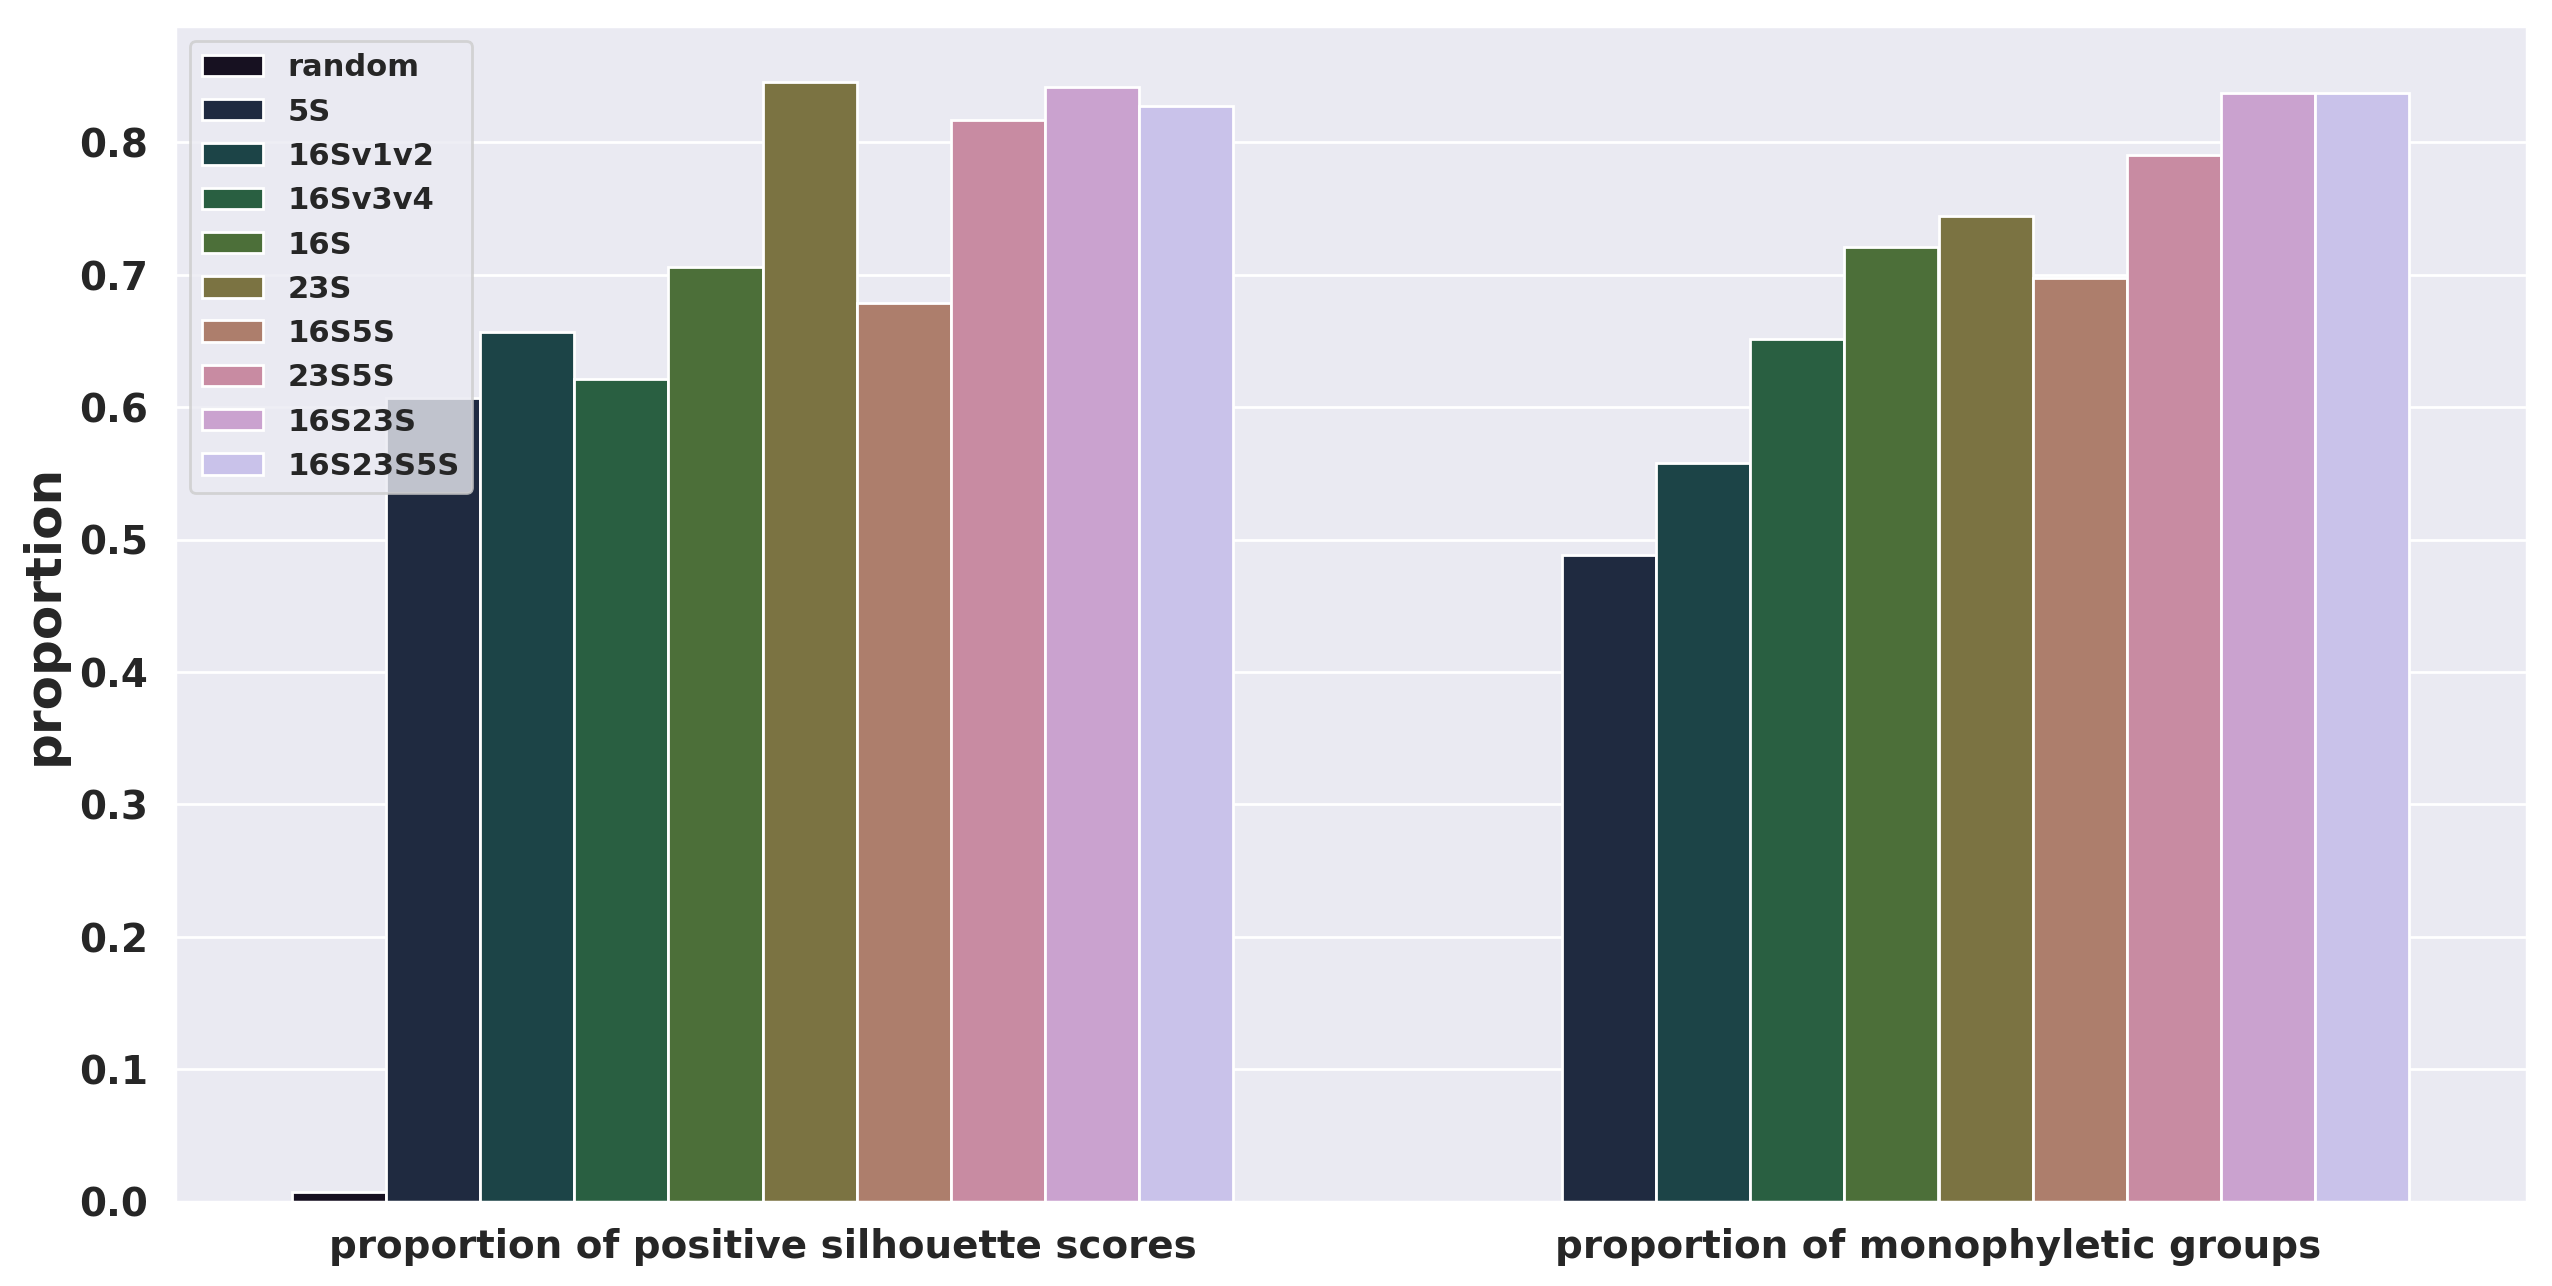

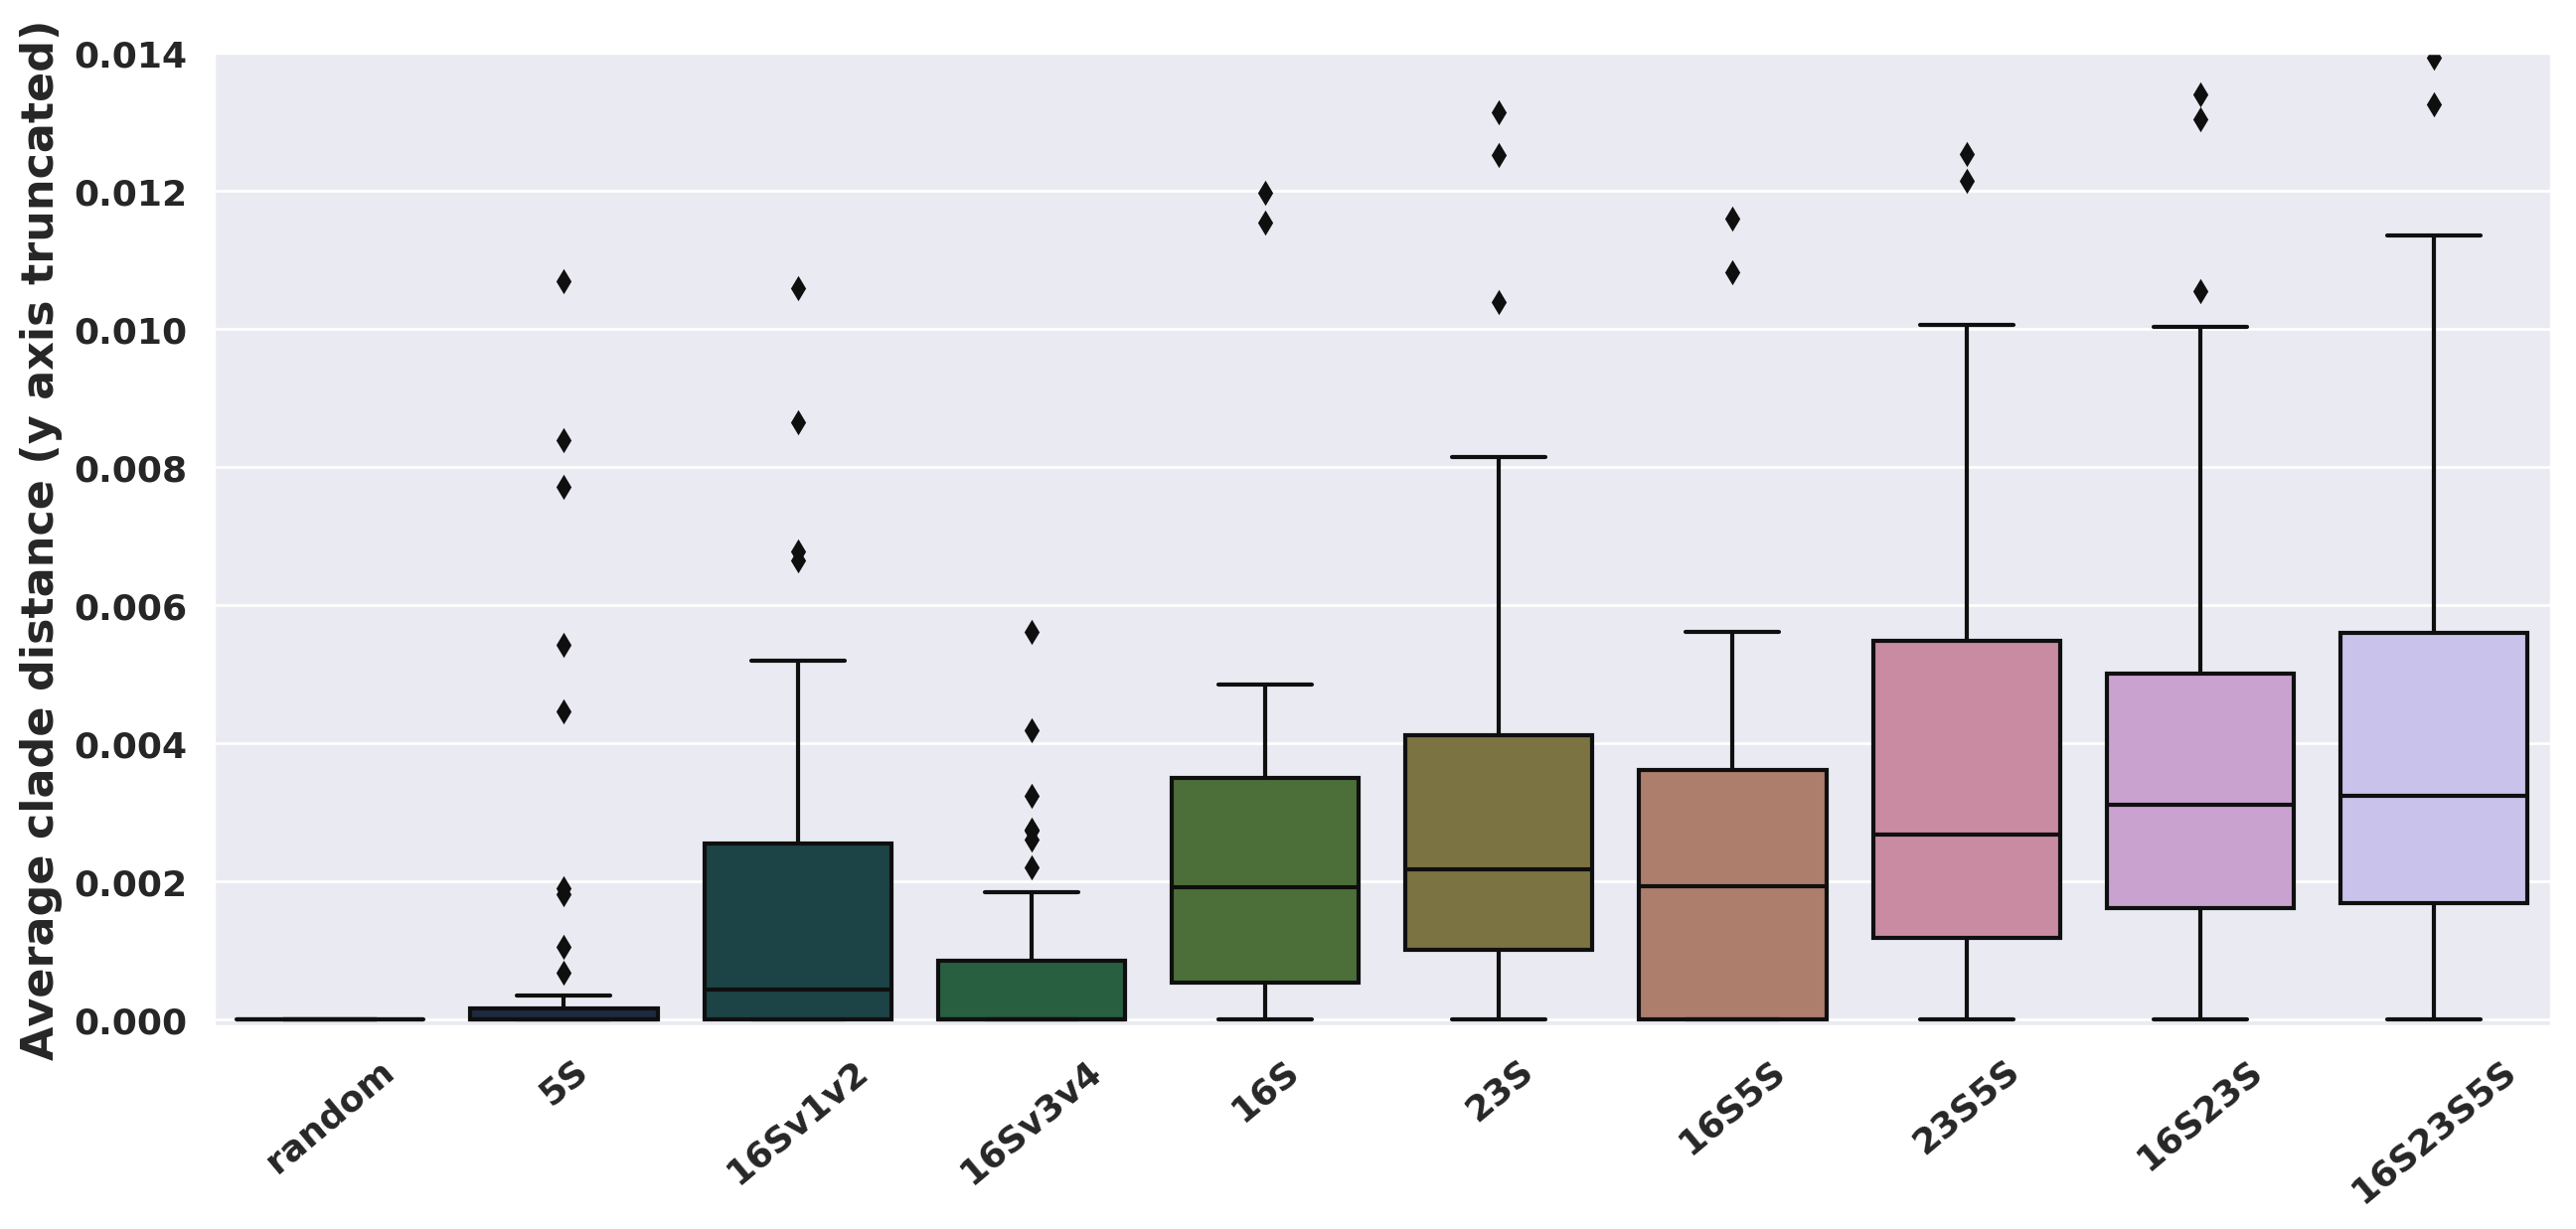

In [63]:
fig, axes = plt.subplots(3,1) ; fig.set_size_inches(16, 24); 
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rc('font', weight='bold')
fig.subplots_adjust(top=.91, bottom=.01, left=.02, right=.99, wspace=.2, hspace=.2)

sns.set(); 
sns.set_palette("cubehelix", 12);
sns.boxenplot(x=vio_silho_x, y=vio_silho_y, ax = axes[0], outlier_prop=0.00001)
axes[0].set_ylabel("tree silhouette scores", fontsize=22, weight="bold") # "silhouette scores from patristic distances"
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=40)
axes[0].tick_params(labelsize=16)

sns.set(); sns.set_palette("cubehelix", 12)
sns.pointplot(x=vio_mono_x, y=vio_mono_y, ax = axes[1], linestyles="--", errwidth=0.5, color="gray", scale=0.4)
sns.swarmplot(x=vio_mono_x, y=vio_mono_y, ax = axes[1], size=10, linewidth=1)
axes[1].set_ylabel("monophyly scores", fontsize=22, weight="bold")
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=40)
axes[1].tick_params(labelsize=16)

sns.set(); sns.set_palette("cubehelix", 12) # "Average distance between samples from best monophyletic subtree"
sns.boxplot(x=vio_mono_x, y=vio_mav_y, ax = axes[2]) 
axes[2].set_ylabel("Average clade distance", fontsize=22, weight="bold")
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=40)
#axes[2].set_ylim(-0.0001,0.015)
axes[2].tick_params(labelsize=16)
#sns.boxplot(x=rnatypelist, y=monolist_sp, ax = axes[1])  # inner="sticks",
#sns.pointplot(x=rnatypelist, y=monolist_sp, ax = axes[1])  

fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6); 
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.99, wspace=.1, hspace=.1)
sns.set(); sns.set_palette("cubehelix", 12)
sns.barplot(hue=bplot_label, y=bplot_value, x=bplot_hue, ax=axes)
axes.set_ylabel("proportion", fontsize=18, fontweight="bold")
axes.tick_params(labelsize=14)
#axes.set_title("proportion of sample pairs with good silhouettes and proportion of monophyletic groups")

fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 5); 
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.99, wspace=.1, hspace=.1)
sns.set(); sns.set_palette("cubehelix", 12) # "Average distance between samples from best monophyletic subtree"
sns.boxplot(x=vio_mono_x, y=vio_mav_y, ax = axes) 
axes.set_ylabel("Average clade distance (y axis truncated)", fontsize=16, weight="bold")
axes.set_xticklabels(axes.get_xticklabels(),rotation=40)
axes.set_ylim(-0.0001,0.014)
axes.tick_params(labelsize=13)

# Scores using alternative taxonomic classifications
- actually this function works for any combination (long/consensus, ML/upgma, taxon DB)

In [9]:
rand_tfile = outfile_list[0]+ "_consensus.fasta.treefile" # or _long, we just use leaf names
suffix1 = ".fasta.treefile"
#suffix1 = "_upgma.treefile"
suffix2 = "_long"
#suffix2 = "_consensus"
suffix = suffix2 + suffix1;
table_col = 0 ## 0 GTDB, 1 silvaLSU, 3 NCBI, or 4 silvaSSU
title_list = ["GTDB", "LSU SILVA", "unused", "NCBI", "SSU SILVA"]

## Silhouette scores
mdis, mnod = patristic_distances_from_treefile (rand_tfile, tbl_col = table_col, shuffle = True)
bplot_label = ["random"] ; bplot_hue = ["proportion of positive silhouette scores"]; 
bplot_value = [sum(mnod>0)/float(len(mnod))]
# violin plots use weighted distances
vio_silho_x = ["random"] * mdis.shape[0];  vio_silho_y = list(mdis)
print ("Silhouette\n", silhouette_str_head)
print ('   {:9s}'.format("random"), "\t", silhouette_str(mdis),  silhouette_str(mnod))

for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
    mdis, mnod = patristic_distances_from_treefile (fname + suffix)
    print (suffix2 + ' {:6s}'.format(rname), "\t", silhouette_str(mdis),  silhouette_str(mnod))
    bplot_label.append(rname) ; bplot_hue.append("proportion of positive silhouette scores");
    bplot_value.append(sum(mnod>0)/float(len(mnod)))
    vio_silho_x.extend([str(rname)] * mdis.shape[0]); vio_silho_y.extend(list(mdis))

##  Monophyly scores
mono, fspec, mav, avv = monophyly_score_from_treefile (rand_tfile, tbl_col = table_col, shuffle = True)
bplot_label.append("random") ; bplot_hue.append("proportion of monophyletic groups")
bplot_value.append(sum(np.array(fspec) > 0.999)/float(len(fspec)))
vio_mono_x = ["random"] * len(mono)
vio_mono_y = mono; vio_mav_y = mav

print ("\nMonophyly\n", mono_str_head)
print ('{:9s}'.format("random"), "\t", mono_str(mono, fspec, mav, avv))

for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
    mono, fspec, mav, avv = monophyly_score_from_treefile (fname + suffix)
    print (suffix2 + ' {:7s}'.format(rname), "\t", mono_str(mono, fspec, mav, avv))
    bplot_label.append(rname) ; bplot_hue.append("proportion of monophyletic groups")
    bplot_value.append(sum(np.array(fspec) > 0.999)/float(len(fspec)))
    vio_mono_x.extend([rname] * len(mono))
    vio_mono_y.extend(mono); vio_mav_y.extend(mav);

Silhouette
 5%  25%  50%  75%  proportion_positives   <-- weighted | unweighted -->
   random    	  -0.901 -0.867 -0.559 -0.397  0.010    -0.400 -0.295 -0.239 -0.193  0.014  
_long 5S     	  -0.998 -0.336  0.459  0.997  0.657    -0.621 -0.238  0.122  0.485  0.591  
_long 16Sv1v2 	  -0.964  0.113  0.793  0.952  0.786    -0.379 -0.044  0.233  0.459  0.688  
_long 16Sv3v4 	  -0.931  0.053  0.870  0.987  0.772    -0.595 -0.120  0.294  0.564  0.671  
_long 16S    	  -0.440  0.158  0.742  0.956  0.820    -0.262  0.064  0.306  0.470  0.817  
_long 23S    	   0.086  0.516  0.801  0.949  0.952    -0.199  0.249  0.382  0.506  0.901  
_long 16S5S  	  -0.415  0.296  0.749  0.949  0.839    -0.250  0.052  0.325  0.482  0.795  
_long 23S5S  	  -0.269  0.491  0.792  0.948  0.924    -0.342  0.273  0.438  0.525  0.876  
_long 16S23S 	   0.128  0.539  0.753  0.954  0.963    -0.189  0.278  0.435  0.511  0.895  
_long 16S23S5S 	   0.028  0.495  0.748  0.951  0.957    -0.214  0.259  0.421  0.521  0.901  

M

Text(0.5, 1.0, 'GTDB')

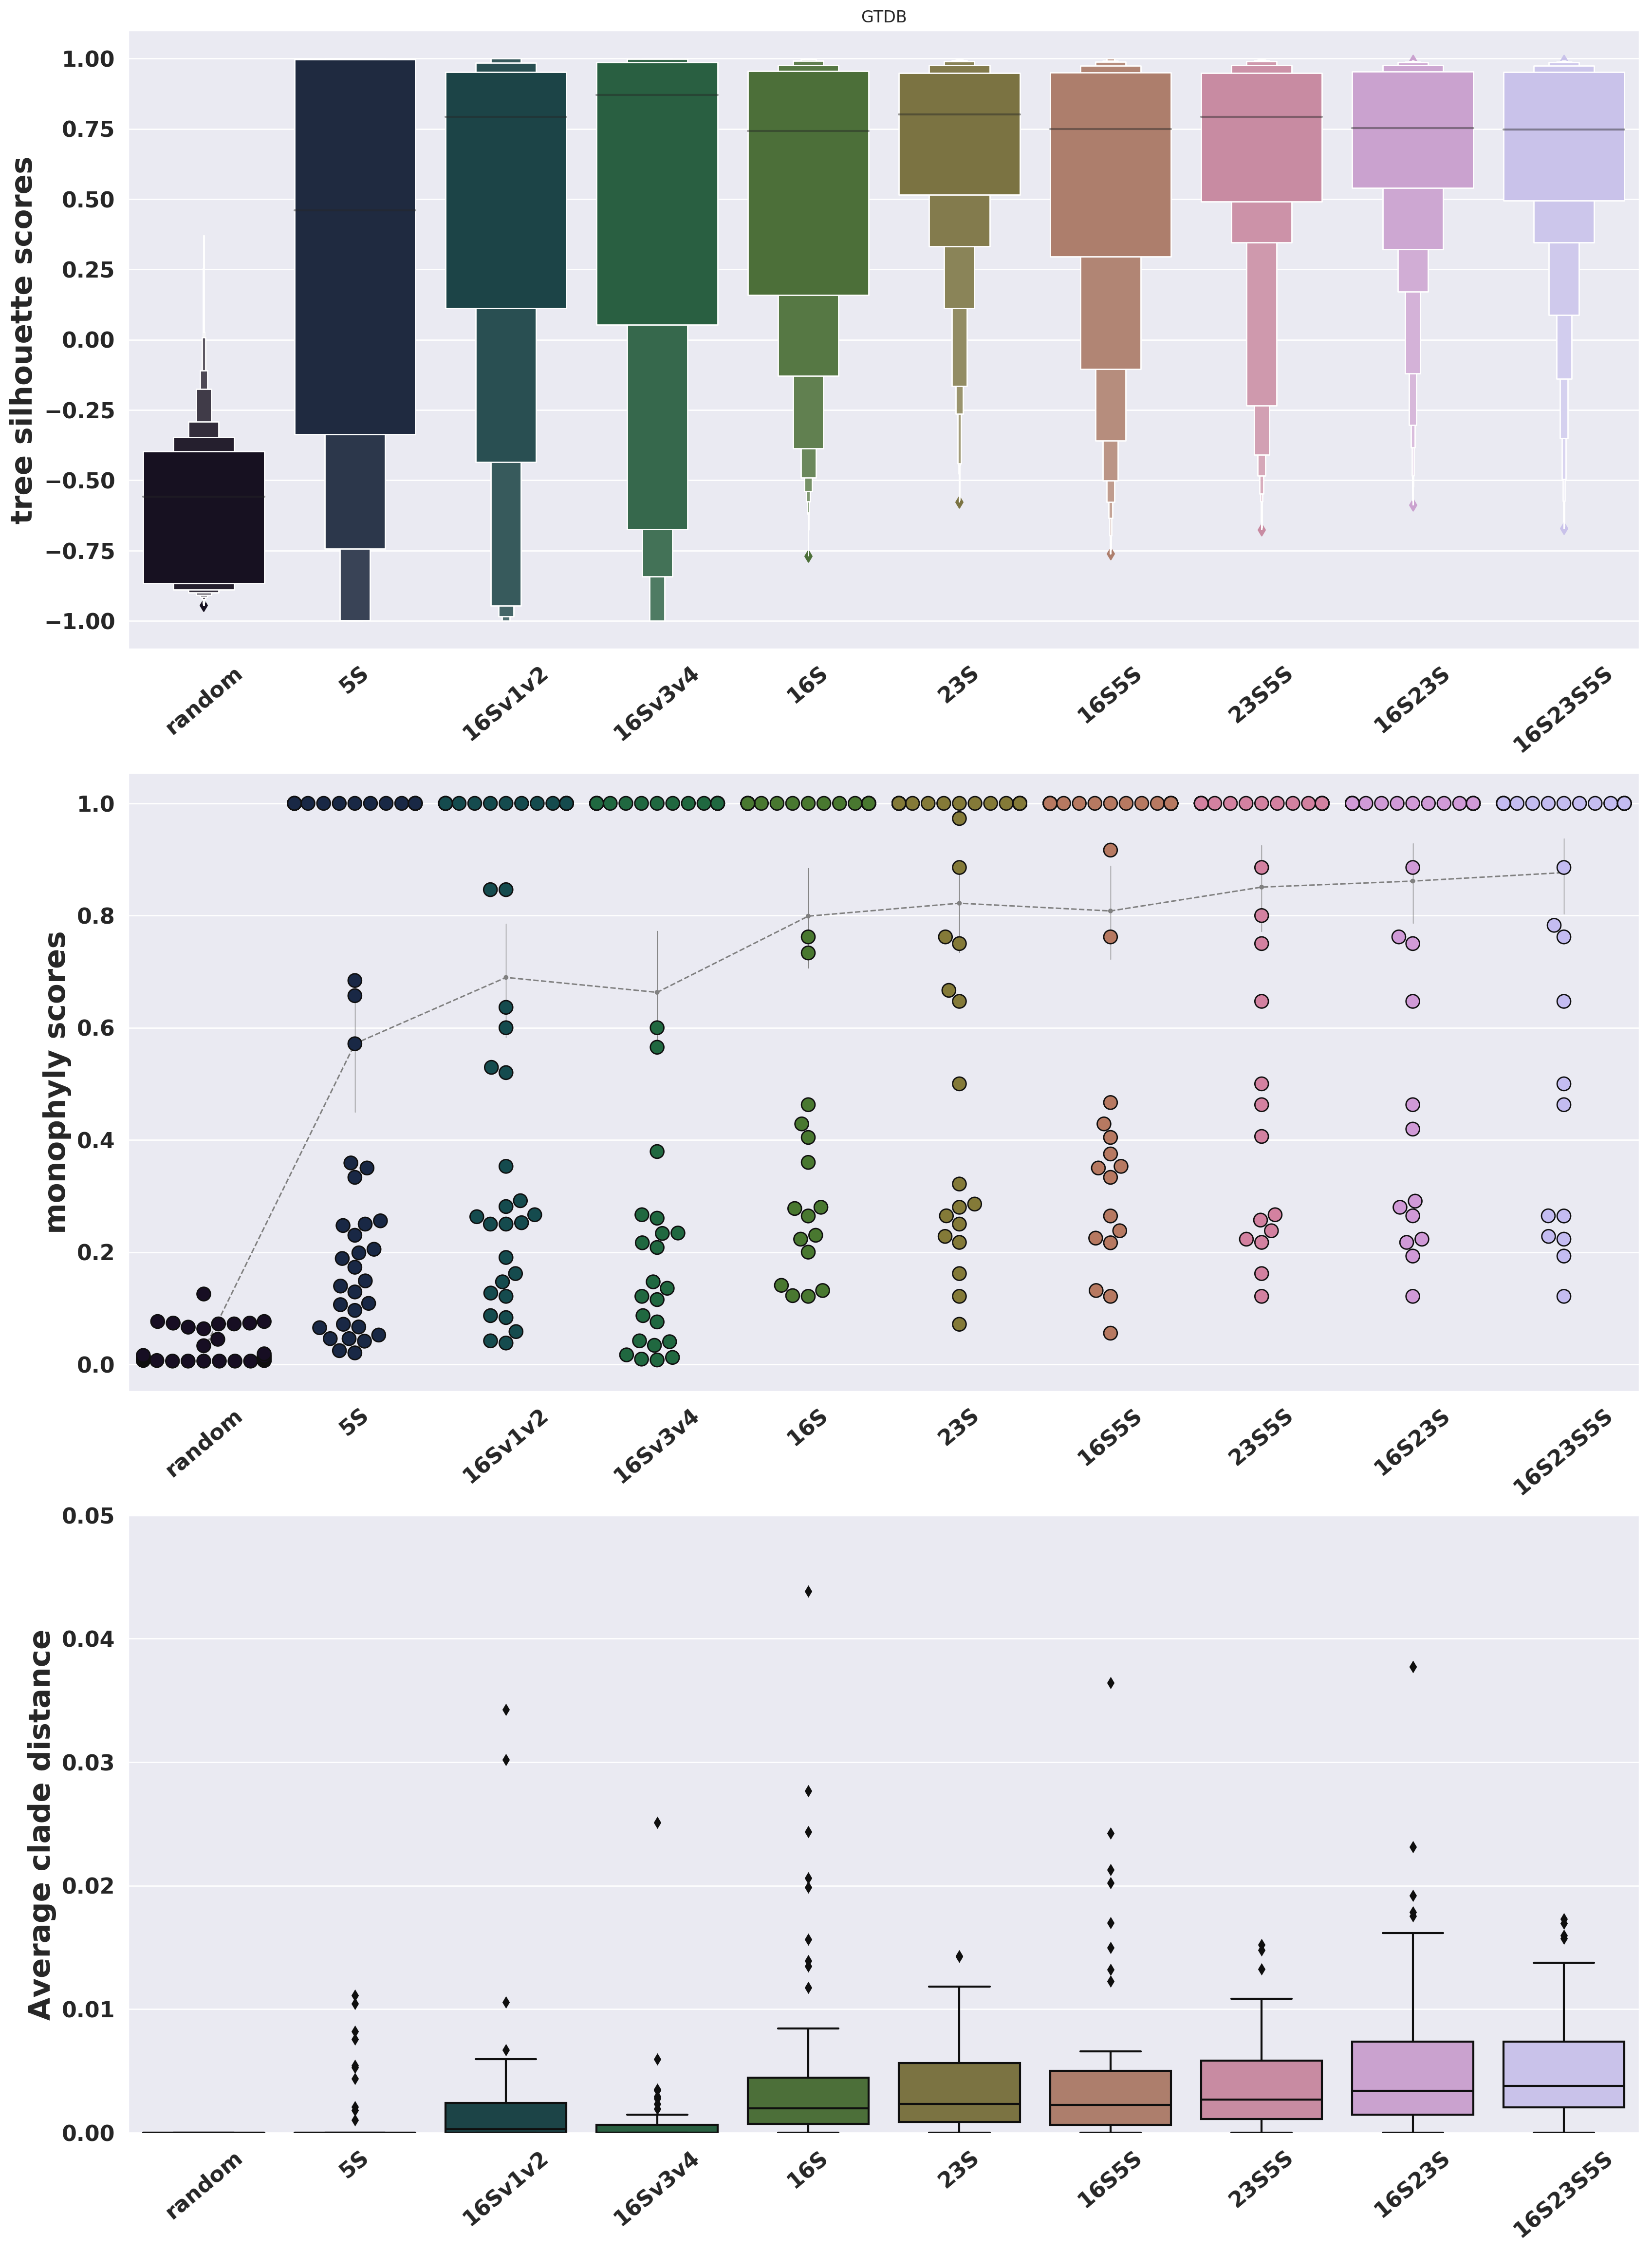

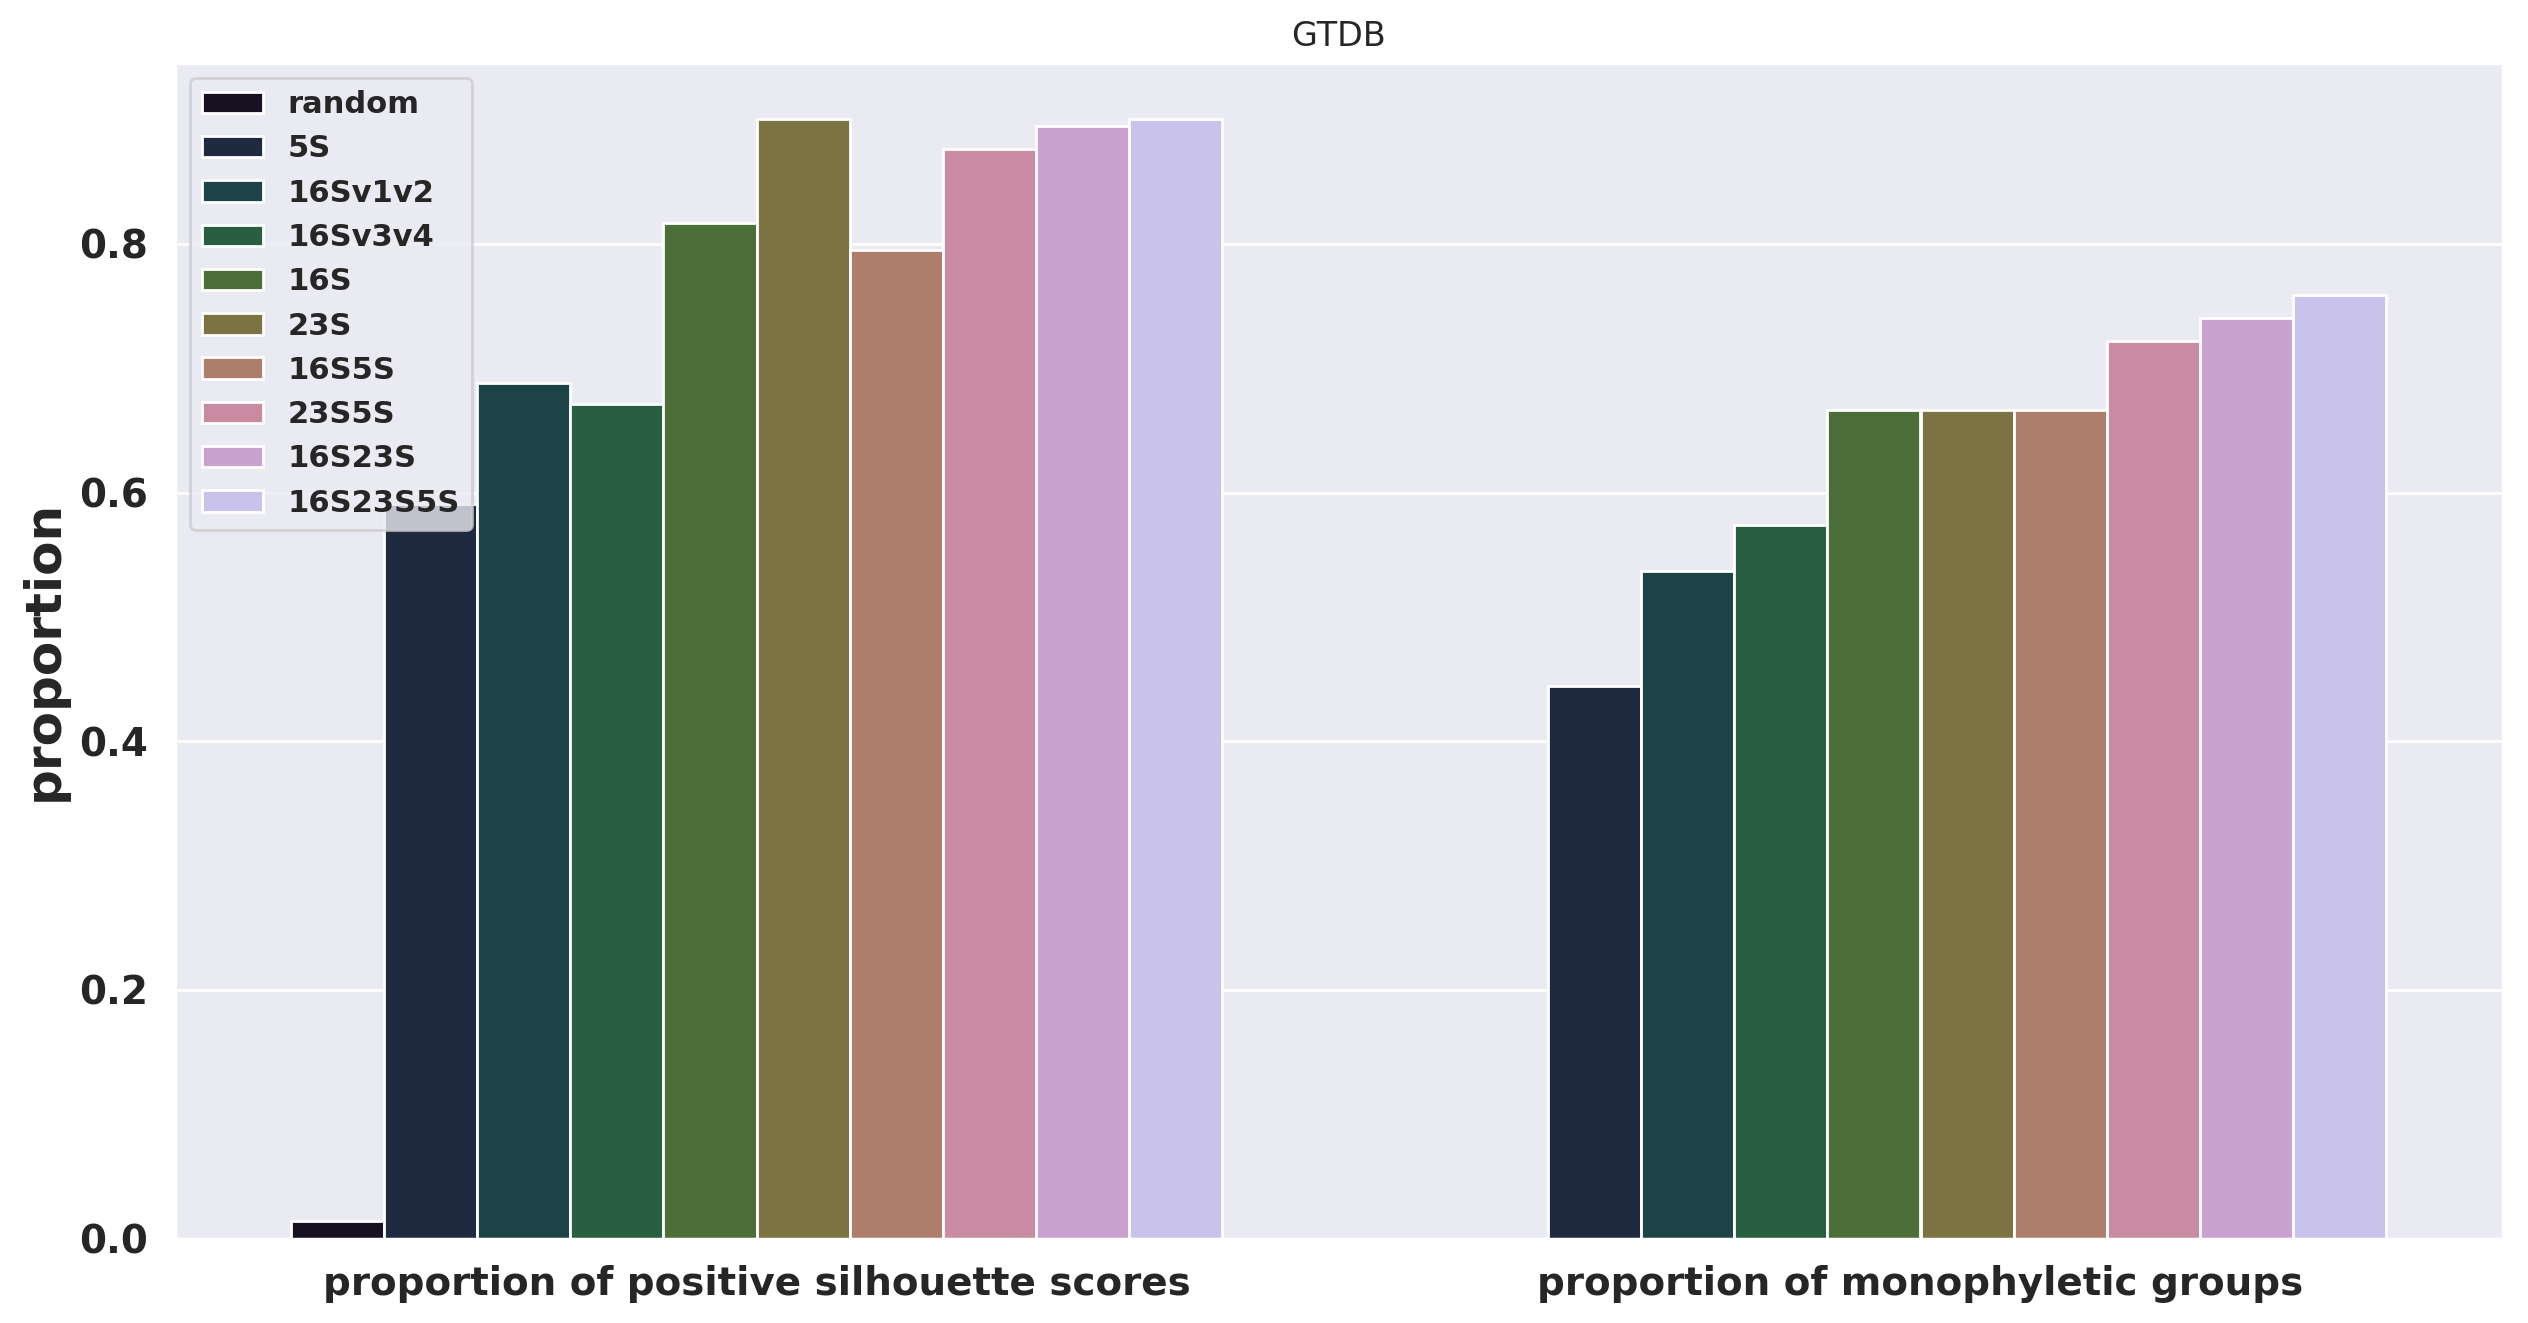

In [11]:
fig, axes = plt.subplots(3,1) ; fig.set_size_inches(16, 24); 
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rc('font', weight='bold')
fig.subplots_adjust(top=.91, bottom=.01, left=.02, right=.99, wspace=.2, hspace=.2)

sns.set(); 
sns.set_palette("cubehelix", 12);
sns.boxenplot(x=vio_silho_x, y=vio_silho_y, ax = axes[0], outlier_prop=0.00001)
axes[0].set_ylabel("tree silhouette scores", fontsize=22, weight="bold") # "silhouette scores from patristic distances"
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=40)
axes[0].tick_params(labelsize=16)
axes[0].set_title(title_list[table_col])

sns.set(); sns.set_palette("cubehelix", 12)
sns.pointplot(x=vio_mono_x, y=vio_mono_y, ax = axes[1], linestyles="--", errwidth=0.5, color="gray", scale=0.4)
sns.swarmplot(x=vio_mono_x, y=vio_mono_y, ax = axes[1], size=10, linewidth=1)
axes[1].set_ylabel("monophyly scores", fontsize=22, weight="bold")
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=40)
axes[1].tick_params(labelsize=16)

sns.set(); sns.set_palette("cubehelix", 12) # "Average distance between samples from best monophyletic subtree"
sns.boxplot(x=vio_mono_x, y=vio_mav_y, ax = axes[2]) 
axes[2].set_ylabel("Average clade distance", fontsize=22, weight="bold")
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=40)
axes[2].set_ylim(-0.0001,0.05)
axes[2].tick_params(labelsize=16)

fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6); 
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.98, wspace=.2, hspace=.2)
sns.set(); sns.set_palette("cubehelix", 12)
sns.barplot(hue=bplot_label, y=bplot_value, x=bplot_hue, ax=axes)
axes.set_ylabel("proportion", fontsize=18, fontweight="bold")
axes.tick_params(labelsize=14)
axes.set_title(title_list[table_col])